<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club/blob/main/Lending_Club_Loan_Charge_Off_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OVERVIEW**

### **Objective:**
This notebook demonstrates the end-to-end process of building a **Loan Charge-Off Prediction Model** for Lending Club, designed to estimate the likelihood that an approved loan will eventually be charged off, using borrower profile features and loan attributes available at origination.

### **Business Context:**
Charge-offs result in direct financial losses and degrade overall portfolio performance. By predicting charge-off risk at the time of funding, this model supports **post-approval risk stratification**, enabling Lending Club to refine pricing, monitoring, and servicing strategies.

### **Techniques & Tools**:
* **XGBoost** for modeling technique
* **PySpark & Python** (Pandas, scikit-learn, Matplotlib, Seaborn) for data processing, feature engineering, and evaluation.

##### **Author:**  Nhat Linh Tran

# **A. NOTEBOOK SETUP**

In [ ]:
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')

Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [ ]:
!pip install PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os

print('Import Libraries')

Import Libraries


In [ ]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [ ]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# **B. BUILD DATASET**


The Datatset is based on approved loans dataset with 'loan_status' is in:
* "Fully Paid"
* "Charged Off"
* "Does not meet the credit policy. Status:Charged Off"


### **Feature Selection**:

#### **Borrower Information**
* loan_amnt
* term
* int_rate
* installment
* purpose
* application_type
* grade
* sub_grade
* home_ownership
* emp_length_years
* CO_flag

#### **Income**
* annual_inc
* dti

#### **Credit Behavior**
* fico_range_low, fico_range_high
* open_acc: # of currently active credit lines
* total_acc
* total_cur_bal_ex_mort
* revol_util: Revolving line utilization rate


#### **Credit History**
* delinq_2yrs: # of times borrower was 30+ days delinquent in the past 2yrs
* inq_last_6mths: # hard credit inquiries in the last 6 months
* acc_now_delinq: # of accounts currently delinquent
* percent_bc_gt_75: Percentage of all bankcard accounts > 75% of limit
* pct_tl_nvr_dlq: Percent of total credit accounts that were never delinquent
* num_tl_30dpd: # of accounts currently 30dpd
* num_tl_90g_dpd_24m
* num_tl_120dpd_2m
* mths_since_last_major_derog: Months since most recent 90-day or worse rating
* collections_12_mths_ex_med
* chargeoff_within_12_mths
* pub_rec: # of derogatory public records
* pub_rec_bankruptcies: # of public record bankruptcies
* months_of_credit =  issue_d -  earliest_cr_line

## **1. Initial Dataset Construction**

In [ ]:
df = accepted_df.filter(col("loan_status").isin(["Fully Paid",
                                                 "Default",
                                                 "Charged Off",
                                                 "Does not meet the credit policy. Status:Charged Off"])) \
                .filter(col('revol_util') <= 100) \
                .filter((col('dti') >= 0) & (col('dti') <= 100)) \
                .withColumn('dti', when(col('dti') > 50, 50).otherwise(col('dti')))
                .withColumn("CO_flag", when(col("loan_status").isin(["Default", "Charged Off", "Does not meet the credit policy. Status:Charged Off"]), 1).otherwise(0)) \
                .withColumn("issue_d", to_date(col("issue_d"), "MMM-yyyy")) \
                .withColumn("earliest_cr_line", to_date(col("earliest_cr_line"), "MMM-yyyy")) \
                .withColumn("months_of_credit", round(months_between(col("issue_d"), col("earliest_cr_line"))).cast("int")) \
                .withColumn('emp_length_years', when(col('emp_length') == '< 1 year', 0)
                                               .when(col('emp_length') == '1 year', 1)
                                               .when(col('emp_length') == '2 years', 2)
                                               .when(col('emp_length') == '3 years', 3)
                                               .when(col('emp_length') == '4 years', 4)
                                               .when(col('emp_length') == '5 years', 5)
                                               .when(col('emp_length') == '6 years', 6)
                                               .when(col('emp_length') == '7 years', 7)
                                               .when(col('emp_length') == '8 years', 8)
                                               .when(col('emp_length') == '9 years', 9)
                                               .when(col('emp_length') == '10+ years', 10)
                                               .when(col('emp_length').isNull(), None).otherwise(None))

## **2. Quantile Analysis - Distribution Check**

In [ ]:
numeric_cols = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti", "months_of_credit",
    "open_acc", "total_acc", "revol_bal", "revol_util", "tot_cur_bal", "total_rev_hi_lim",
    "inq_last_6mths", "delinq_2yrs", "collections_12_mths_ex_med", "mths_since_last_major_derog",
    "pub_rec", "pub_rec_bankruptcies", "months_of_credit"
]

quantiles = [0.01, 0.25, 0.5, 0.75, 0.95, 0.99]

for col_name in numeric_cols:
    print(f"Column: {col_name}")
    print(df.approxQuantile(col_name, quantiles, 0.01))
    print("------")

Column: loan_amnt
[500.0, 8000.0, 12000.0, 20000.0, 32000.0, 40000.0]
------
Column: int_rate
[5.31, 9.75, 12.69, 15.99, 21.99, 30.99]
------
Column: installment
[4.93, 247.97, 377.38, 572.09, 929.89, 1719.83]
------
Column: annual_inc
[430.0, 46000.0, 65000.0, 92000.0, 156000.0, 10999200.0]
------
Column: dti
[0.0, 11.78, 17.51, 23.85, 33.45, 50.0]
------
Column: months_of_credit
[6.0, 134.0, 177.0, 238.0, 363.0, 999.0]
------
Column: open_acc
[1.0, 8.0, 11.0, 15.0, 22.0, 90.0]
------
Column: total_acc
[1.0, 17.0, 24.0, 32.0, 48.0, 176.0]
------
Column: revol_bal
[0.0, 5787.0, 10982.0, 19255.0, 46301.0, 2904836.0]
------
Column: revol_util
[0.0, 33.6, 52.1, 70.1, 90.8, 100.0]
------
Column: tot_cur_bal
[0.0, 29355.0, 81793.0, 208969.0, 432757.0, 8000078.0]
------
Column: total_rev_hi_lim
[0.0, 13800.0, 24100.0, 40200.0, 89500.0, 9999999.0]
------
Column: inq_last_6mths
[0.0, 0.0, 0.0, 1.0, 3.0, 33.0]
------
Column: delinq_2yrs
[0.0, 0.0, 0.0, 0.0, 2.0, 39.0]
------
Column: collections

## **3. Refined Dataset**
Apply additional filters and caps informed by quantile analysis to ensure meaningful, realistic values

In [ ]:
final_df = accepted_df.filter(col("loan_status").isin(["Fully Paid",
                                                 "Default",
                                                 "Charged Off",
                                                 "Does not meet the credit policy. Status:Charged Off"])) \
                .filter((col('dti') >= 0) & (col('dti') <= 100)) \
                .filter(col('revol_util') <= 100) \
                .filter((col('annual_inc') >= 29000) & (col('annual_inc') <= 156000)) \
                .filter(col('total_acc') <= 48) \
                .filter(col('open_acc') <= 22) \
                .withColumn('cur_bal_to_ratio', col('total_bal_ex_mort') / col('annual_inc')) \
                .filter(col('cur_bal_to_ratio') <= 10) \
                .withColumn("CO_flag", when(col("loan_status").isin(["Default", "Charged Off", "Does not meet the credit policy. Status:Charged Off"]), 1).otherwise(0)) \
                .withColumn("issue_d", to_date(col("issue_d"), "MMM-yyyy")) \
                .withColumn("earliest_cr_line", to_date(col("earliest_cr_line"), "MMM-yyyy")) \
                .withColumn("months_of_credit", round(months_between(col("issue_d"), col("earliest_cr_line"))).cast("int")) \
                .filter(col('months_of_credit') <= 600) \
                .withColumn('emp_length_years', when(col('emp_length') == '< 1 year', 0)
                                               .when(col('emp_length') == '1 year', 1)
                                               .when(col('emp_length') == '2 years', 2)
                                               .when(col('emp_length') == '3 years', 3)
                                               .when(col('emp_length') == '4 years', 4)
                                               .when(col('emp_length') == '5 years', 5)
                                               .when(col('emp_length') == '6 years', 6)
                                               .when(col('emp_length') == '7 years', 7)
                                               .when(col('emp_length') == '8 years', 8)
                                               .when(col('emp_length') == '9 years', 9)
                                               .when(col('emp_length') == '10+ years', 10)
                                               .when(col('emp_length').isNull(), -1)) \
                .withColumn('emp_length_years_isNull', when(col('emp_length_years') == -1, 1).otherwise(0)) \
                .withColumn('dti', when(col('dti') > 50, 50).otherwise(col('dti'))) \
                .fillna(-1, subset = ['pct_tl_nvr_dlq']) \
                .withColumn('pct_tl_nvr_dlq_isNull', when(col('pct_tl_nvr_dlq') == -1, 1).otherwise(0)) \
                .dropna(subset = ['total_bal_ex_mort', 'inq_last_6mths']) \
                .select(
                        "loan_amnt", "term", "int_rate", "installment", "application_type", "grade", "emp_length_years", "emp_length_years_isNull",

                        "annual_inc", "dti", "fico_range_low", "fico_range_high",
                        "open_acc", "total_acc", "total_bal_ex_mort", "revol_util",
                        "inq_last_6mths", "pct_tl_nvr_dlq", "pct_tl_nvr_dlq_isNull",
                        "delinq_2yrs", "chargeoff_within_12_mths",
                        "pub_rec", "pub_rec_bankruptcies", "months_of_credit",

                        "CO_flag"
                )

In [ ]:
# Imbalanced Dataset

print('Total Records: ', final_df.count())
final_df.groupBy('CO_flag').count().show()

Total Records:  1078665
+-------+------+
|CO_flag| count|
+-------+------+
|      1|215763|
|      0|862902|
+-------+------+



In [ ]:
# Descriptive Statistics & Null Checks

final_df.describe().show()
final_df.select([count(when(col(c).isNull(), c)).alias(c) for c in final_df.columns]).show()

+-------+-----------------+----------+------------------+------------------+----------------+-------+-----------------+-----------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------------+-------------------+--------------------+------------------+-------------------+
|summary|        loan_amnt|      term|          int_rate|       installment|application_type|  grade| emp_length_years|emp_length_years_isNull|        annual_inc|               dti|   fico_range_low|   fico_range_high|          open_acc|         total_acc| total_bal_ex_mort|        revol_util|    inq_last_6mths|   pct_tl_nvr_dlq|pct_tl_nvr_dlq_isNull|        delinq_2yrs|chargeoff_within_12_mths|            pub_rec|pub_rec_bankruptcies|  months_of_credit|            CO_flag|
+-------+-----------------+----------+----

# **C. BUILD LOAN CHARGE-OFF PREDICTION MODEL**

## **1. Assemble Features**

In [ ]:
# Libraries

from xgboost.spark import SparkXGBClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score

In [ ]:
# Categorical Encoding Pipeline

categorical_cols = ['grade', 'term', 'application_type']

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_cols]

encoder = OneHotEncoder(
    inputCols=[f"{c}_index" for c in categorical_cols],
    outputCols=[f"{c}_encoded" for c in categorical_cols]
)

In [ ]:
# Feature Assembly

isNull_cols  = ['emp_length_years_isNull', 'pct_tl_nvr_dlq_isNull']
exclude_cols = ['CO_flag'] + categorical_cols + isNull_cols
numeric_cols = [c for c in final_df.columns if c not in exclude_cols]
encoded_cols = [f"{c}_encoded" for c in categorical_cols]
final_features = numeric_cols + encoded_cols + isNull_cols

assembler = VectorAssembler(inputCols=final_features, outputCol="features")

In [ ]:
# Processing Pipeline & Transforming

pipeline = Pipeline(stages=indexers + [encoder, assembler])
processed = pipeline.fit(final_df).transform(final_df)

## **2. Train XGBoost Model**

In [ ]:
# Train - Test Split
train_df, test_df = processed.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Train Model

xgb = SparkXGBClassifier(
    features_col="features",
    label_col="CO_flag",
    prediction_col="prediction",
    probability_col="probability",
    rawPrediction_col="rawPrediction",
    numRound=500,
    maxDepth=6,
    minChildWeight=5,
    eta=0.1,
    scalePosWeight=4,          # class imbalance (Fully Paid:CO ≈ 4:1)
    max_delta_step=1,
    alpha=0.5,
    lambda_=1.0,
    evalMetric="auc",
    seed=42
)

model = xgb.fit(train_df)

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_delta_step': 1, 'rawPrediction_col': 'rawPrediction', 'numRound': 500, 'maxDepth': 6, 'minChildWeight': 5, 'eta': 0.1, 'scalePosWeight': 4, 'alpha': 0.5, 'lambda_': 1.0, 'evalMetric': 'auc', 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


# **D. MODEL EVALUATION**

## **1. AUC, Classification Report, Confusion Matrix**

In [ ]:
# AUC

# Predict on test set
predictions = model.transform(test_df)

# Evaluate AUC (ROC)
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="CO_flag", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
auc_score = evaluator_roc.evaluate(predictions)
print("AUC:", auc_score)

AUC: 0.7155620656204926


              precision    recall  f1-score   support

  Fully Paid       0.81      0.99      0.89    172463
  Charge-Off       0.55      0.07      0.12     42974

    accuracy                           0.80    215437
   macro avg       0.68      0.53      0.50    215437
weighted avg       0.76      0.80      0.74    215437



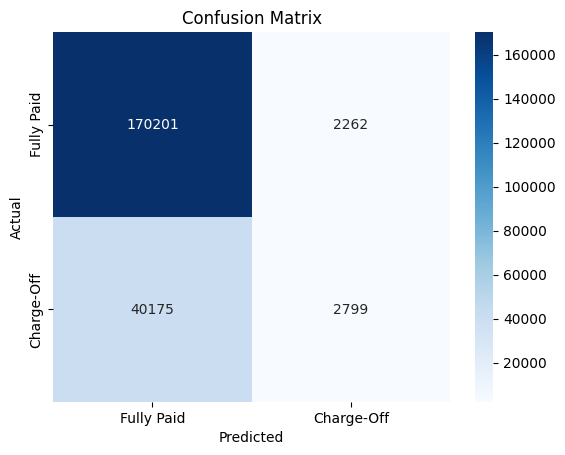

In [ ]:
# Classification Report, Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds_pd = predictions.select("CO_flag", "prediction").toPandas()
print(classification_report(preds_pd["CO_flag"], preds_pd["prediction"], target_names=["Fully Paid", "Charge-Off"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["CO_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Fully Paid", "Charge-Off"], yticklabels=["Fully Paid", "Charge-Off"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## **2. Feature Importance**

### a. XGBoost Feature Importance

In [ ]:
# Fit the pipeline model
pipeline_model = pipeline.fit(final_df)

# Extract encoder and assembler
encoder = pipeline_model.stages[-2]
assembler = pipeline_model.stages[-1]

# Extract input/output columns from encoder
cat_input_cols = encoder.getInputCols()
indexer_labels = {
    stage.getOutputCol(): stage.labels
    for stage in pipeline_model.stages
    if "StringIndexer" in stage.__class__.__name__
}

# Create human-readable feature names from categorical encodings
encoded_cat_features = []
for col in cat_input_cols:
    labels = indexer_labels.get(col, ["unknown"])
    encoded_cat_features += [f"{col}_{label}" for label in labels]

# Combine all features used in the model
final_feature_names = numeric_cols + isNull_cols + encoded_cat_features

# Map XGBoost feature indices to real feature names
booster = model.get_booster()
raw_importance = booster.get_score(importance_type='weight')

# Create DataFrame with mapped names
df_feat_importance = (
    pd.DataFrame([
        (int(k[1:]), v, final_feature_names[int(k[1:])] if int(k[1:]) < len(final_feature_names) else f"unknown_{k}")
        for k, v in raw_importance.items()
    ], columns=["index", "importance", "feature_name"])
    .sort_values(by="importance", ascending=True)
)

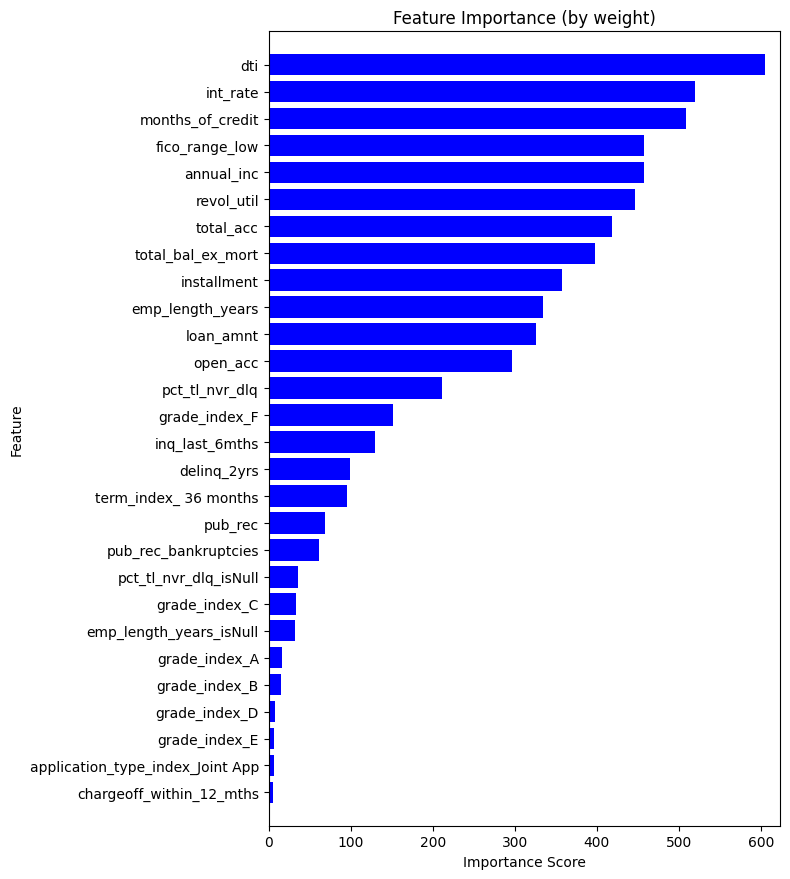

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 0.3 * len(df_feat_importance) + 0.5))

# Plot horizontal bars
ax.barh(
    df_feat_importance['feature_name'],
    df_feat_importance['importance'],
    color='blue'
)

# Add labels and title
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance (by weight)')

# Improve layout
plt.tight_layout()
plt.margins(0.03)
plt.show()

### b. SHAP Values

In [ ]:
sampled_df = processed.select("features", "CO_flag").sample(withReplacement=False, fraction=0.05, seed=42).limit(1000000)

sampled_pd = sampled_df.toPandas()

X = np.array(sampled_pd['features'].tolist())
y = sampled_pd['CO_flag'].values

from xgboost import XGBClassifier
xgb_native = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1,
                           use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_native.fit(X, y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:32:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

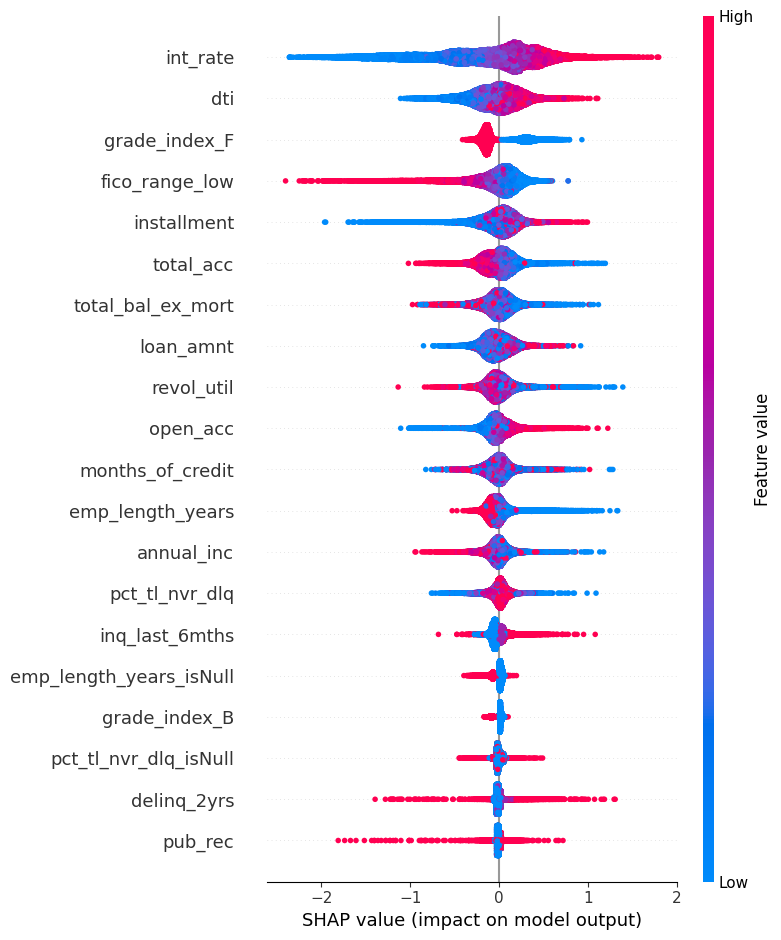

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_native)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=final_feature_names)